In [1]:
from u_net_arch import build_unet
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2025-01-28 19:08:26.543352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 19:08:27.255257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738109307.560955 1938850 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738109307.644078 1938850 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 19:08:28.349094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print("Devices detected:")
print(device_lib.list_local_devices())


TensorFlow version: 2.18.0
Is GPU available: []
Devices detected:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12214640019436805316
xla_global_id: -1
]


2025-01-28 19:08:55.738920: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
large_image_stack = tiff.imread('/home/hice1/dharden7/scratch/sd_proj/img_seg/microscopy_data/training.tif')
large_mask_stack = tiff.imread('/home/hice1/dharden7/scratch/sd_proj/img_seg/microscopy_data/training_groundtruth.tif')

In [4]:
all_img_patches = []
for img in range(large_image_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_image = large_image_stack[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            #scaler = MinMaxScaler()
            #single_patch_img= scaler.fit_transform(single_patch_img)
            
            all_img_patches.append(single_patch_img)

#This will split the image into small images of shape [3,3]
images = np.array(all_img_patches)
images = np.expand_dims(images, -1)


In [5]:
all_mask_patches = []
for img in range(large_mask_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_mask = large_mask_stack[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)


#This will split the image into small images of shape [3,3]
masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.25, random_state = 0)

In [ ]:
# #Sanity check, view few mages
# import random
# import numpy as np
# image_number = random.randint(0, len(X_train))
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
# plt.subplot(122)
# plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
# plt.show()

In [7]:
IMG_HEIGHT = images.shape[1]
IMG_WIDTH  = images.shape[2]
IMG_CHANNELS = images.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [8]:
model = build_unet(input_shape)

model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['loss'])
# model.summary()

In [9]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)


In [10]:
batch_size= 8

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


Image shape:  (256, 256, 1)
Mask shape:  (256, 256, 1)


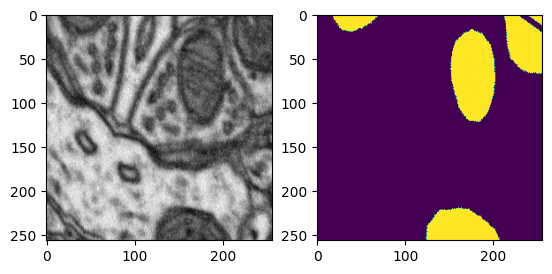

In [11]:
x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    print('Image shape: ', image.shape)
    print('Mask shape: ', mask.shape)
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
# Initialize different loss functions

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f*y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
from tensorflow.keras import regularizers

def set_regularization(model, kernel_regularizer=None, bias_regularizer=None):
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer=kernel_regularizer
        if hasattr(layer, 'bias_regularizer'):
            layer.bias_regularizer=bias_regularizer
            
    # model.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)

# set_regularization(model, kernel_regularizer=keras.regularizers.l2(0.001),bias_regularizer=keras.regularizers.l2(0.001))
set_regularization(model, kernel_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001))


In [55]:
#Add checkpoints 
#filepath='saved_models/models.h5

filepath="/home/hice1/dharden7/scratch/sd_proj/img_seg/models/malaria_augmented_model-{epoch:02d}-{val_loss:.5f}.keras" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [checkpoint, reduce_lr]

steps_per_epoch = 20

In [56]:
# Initialize first model instance
set_regularization(model, kernel_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001))
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=1,
                    callbacks=callbacks_list)
model.save('/home/hice1/dharden7/scratch/sd_proj/img_seg/models/malaria_augmented_model_updated.keras')

KeyboardInterrupt: 

In [40]:
new_model = load_model('/home/hice1/dharden7/scratch/sd_proj/img_seg/models/malaria_augmented_model-01-0.21308.keras')

In [41]:
set_regularization(new_model, kernel_regularizer=tf.keras.regularizers.l2(0.001),bias_regularizer=tf.keras.regularizers.l2(0.001))
# for layer in model.layers:
#     print(layer.get_weights())
new_model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

history = new_model.fit(my_generator, validation_data=validation_datagen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=20,
                    callbacks=callbacks_list)
new_model.save('/home/hice1/dharden7/scratch/sd_proj/img_seg/models/malaria_augmented_model_updated.keras')

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9395 - loss: 0.1999
Epoch 1: val_loss did not improve from 0.33719
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.9405 - loss: 0.1981 - val_accuracy: 0.5065 - val_loss: 4.2321
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9571 - loss: 0.1688
Epoch 2: val_loss improved from 0.33719 to 0.25139, saving model to /home/hice1/dharden7/scratch/sd_proj/img_seg/models/malaria_augmented_model-02-0.25139.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.9573 - loss: 0.1683 - val_accuracy: 0.9262 - val_loss: 0.2514
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9604 - loss: 0.1728
Epoch 3: val_loss did not improve from 0.25139
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.9603 - loss: 0.1719 - val_accuracy: 0.4885 - val_loss: 1.0192
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9520 - loss: 0.1708
Epoch 4: val_loss did not improve from 0.25139
10/10 ━━━━━━━━━━━━━━━

In [42]:
# Evaluate the model for val accuracy/loss
val_steps = 20

val_loss, val_acc = new_model.evaluate(validation_datagen, steps=val_steps)
print(f'Val accuracy: {val_acc}, val loss: {val_loss}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9390 - loss: 0.2807
Val accuracy: 0.9443989992141724, val loss: 0.261909544467926


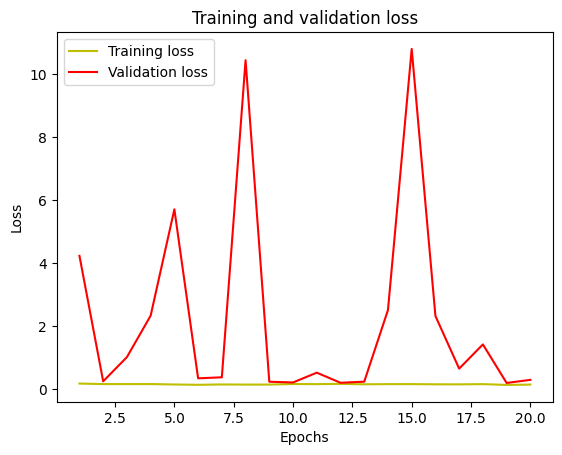

In [43]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


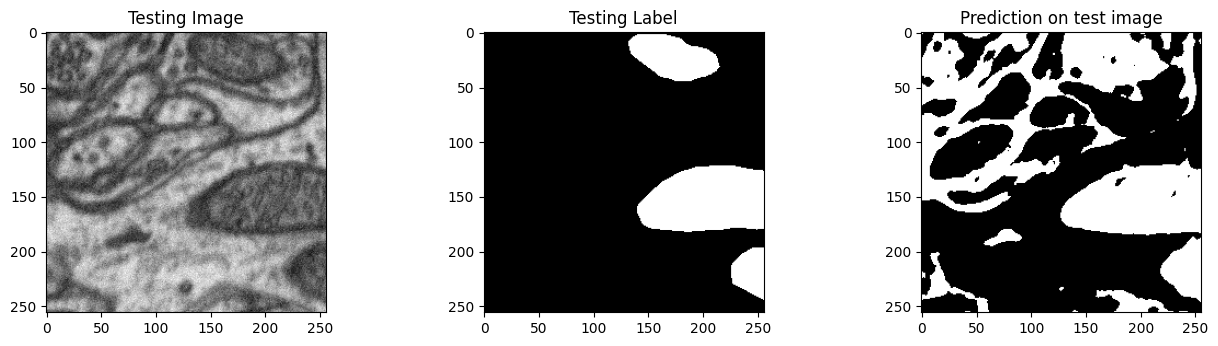

In [49]:
# acc = history.history['accuracy']
#acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# #IOU
# y_pred=new_model.predict(X_test)
# y_pred_thresholded = y_pred > 0.5

# intersection = np.logical_and(y_test, y_pred_thresholded)
# union = np.logical_or(y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

# Predict on a few images
# model = get_model()
# model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
# model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

# test_img_number = np.random.randint(0, len(X_test))
test_img_number = 1
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (new_model.predict(test_img_input)[0,:,:,0] > 0.01).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()